In [1]:
import numpy as np
import cv2
import os
from PIL import Image
from matplotlib import pyplot as plt


In [2]:
"""
Need a measurement of matching
"""

#Main path

KITTI360Path="/media/ren/EXTERNAL_USB/KITTI360_DATASET/"

print(KITTI360Path)
# NoneType=type(None)
def ORB(img):
    """
     ORB detector
    """
    orb = cv2.ORB_create(20000)
    """find keypoint, and calculate descriptor"""
    kp, des = orb.detectAndCompute(img, None)

    # plot keypoints
    # img2 = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=0)

 
    # plt.figure(figsize=(10, 8), dpi=100)
    # plt.imshow(img2[:, :, ::-1])
    # plt.xticks([]), plt.yticks([])
    # plt.show()
    return kp, des



def SIFT(img):
    """
     SIFT detector
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # SIFT keypoint detector
    # sift instantiation 
    sift = cv2.xfeatures2d.SIFT_create()

    # sift detect and compute 
    kp, des = sift.detectAndCompute(gray, None)
    
    # kp: information of keypoint, including position, scale, direction
    # des: keypoint descriptor, corresponds to a feature vector of 128 gradient information

    # image show
    # cv2.drawKeypoints(img, kp, img, (0, 255, 0))

    
    # plt.figure(figsize=(10, 8), dpi=100)
    # plt.imshow(img[:, :, ::-1])
    # plt.xticks([]), plt.yticks([])
    # plt.show()
    return kp, des


def SURF(img):
    surf = cv2.xfeatures2d.SURF_create()
    kp, des = surf.detectAndCompute(img, None)
    # cv2.drawKeypoints(img, kp, img, (0, 255, 0))

    
    # plt.figure(figsize=(10, 8), dpi=100)
    # plt.imshow(img[:, :, ::-1])
    # plt.xticks([]), plt.yticks([])
    # plt.show()
    return kp, des


/media/ren/EXTERNAL_USB/KITTI360_DATASET/


In [5]:
"""
Feature matching method
(1). Brute Force matching
(2). FLAnn Matching
"""


def Brute(img1, img2, kp1, kp2, des1, des2, flag):
    """
    Brute Force matching
    :param img1: image 1
    :param img2: image 2
    :param kp1: keypoints of frame 1
    :param kp2: keypoints of frame 2
    :param des1: descriptor of frame 1
    :param des2: descriptor of frame 2
    :return:
    """
    # if type(des1)!=NoneType and type(des2)!=NoneType:
    if (flag == "SIFT" or flag == "SURF"):
        # SIFT
        bf = cv2.BFMatcher_create(cv2.NORM_L1, crossCheck=True)
        
    else:
        # ORB
        # bf = cv2.BFMatcher_create(cv2.NORM_L1, crossCheck=True)
        bf = cv2.BFMatcher_create(cv2.NORM_HAMMING, crossCheck=True)
    # print('des1',des1.shape)
    # print('des2',des2.shape)
    # ms = bf.knnMatch(des1, des2, k=2)
    ms = bf.match(des1, des2)
    # ms = sorted(ms, key=lambda x: x.distance)
    # img3 = cv2.drawMatches(img1, kp1, img2, kp2, ms, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    # cv2.imshow("Matches", img3)
    # cv2.waitKey(0)
    return ms

# def Brute(img1, img2, kp1, kp2, des1, des2, flag="ORB"):
#     """
#     Brute Force matching
#     :param img1: image 1
#     :param img2: image 2
#     :param kp1: keypoints of frame 1
#     :param kp2: keypoints of frame 2
#     :param des1: descriptor of frame 1
#     :param des2: descriptor of frame 2
#     :return:
#     """
#     if (flag == "SIFT" or flag == "sift"):
#         # SIFT
#         bf = cv2.BFMatcher_create(cv2.NORM_L1, crossCheck=False)
#     else:
#         # ORB
#         bf = cv2.BFMatcher_create(cv2.NORM_HAMMING, crossCheck=False)
#     ms = bf.match(des1, des2)
#     ms = sorted(ms, key=lambda x: x.distance)
#     img3 = cv2.drawMatches(img1, kp1, img2, kp2, ms, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#     # cv2.imshow("Matches", img3)
#     # cv2.waitKey(0)
#     return ms

def FLANN(img1, img2, kp1, kp2, des1, des2, flag):
    """
        2. FLANN matching
        :param img1: image 1
        :param img2: image 2
        :param kp1: keypoints of frame 1
        :param kp2: keypoints of frame 2
        :param des1: descriptor of frame 1
        :param des2: descriptor of frame 2
        :return:
        """
    if (flag == "SIFT" or flag == "SURF"):
        # SIFT
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE,
                            trees=5)
        search_params = dict(check=50)
    else:
        # ORB
        FLANN_INDEX_LSH = 6
        index_params = dict(algorithm=FLANN_INDEX_LSH,
                            table_number=6,
                            key_size=12,
                            multi_probe_level=1)
        
        
        search_params = dict(check=50)
    # define FLANN parameter
    # print('des1',des1.shape)
    # print('des2',des2.shape)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    return matches

In [6]:
"""
optimization matching results
RANSAC(RANdom SAmple Consensus)
"""


def RANSAC(img1, img2, kp1, kp2, matches,MIN_MATCH_COUNT):
    # MIN_MATCH_COUNT = 500
    # store all the good matches as per Lowe's ratio test.
    matchType = type(matches[0])
    good = []
    # print(matchType)
    if isinstance(matches[0], cv2.DMatch):
        # Search for matching
        good = matches
    else:
        # knnMatch
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)
    # print('number',len(good))
    
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

        # M: 3x3 Homography matrix. last number is the error of the transformation between points on original images and target images.
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

        # h, w = img1.shape
        # pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        # dst = cv2.perspectiveTransform(pts, M)
        #
        # img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
    else:
        print
        "Not enough matches are found - %d/%d" % (len(good), MIN_MATCH_COUNT)
        matchesMask = None

    draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                       singlePointColor=None,
                       matchesMask=matchesMask,  # draw only inliers
                       flags=2)
    good_match_len=len(good)
    
    img3 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

    draw_params1 = dict(matchColor=(0, 255, 0),  # draw matches in green color
                        singlePointColor=None,
                        matchesMask=None,  # draw only inliers
                        flags=2)
    # print('matched',kp1.size,kp2.size)
    img33 = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params1)
    print("good len",len(good))
    # print("kp1",kp1[0].distance)

    # cv2.imshow("before", img33)
    # cv2.imshow("now", img3)
    # cv2.imwrite('matching testdata00_0000.jpg',img3)
    # cv2.waitKey(20)
    return good_match_len


In [7]:
frame_idx=[]

matching_num_orb=[]

matching_num_sift=[]

matching_num_surf=[]
# realimages_path=os.path.join(KITTI360Path,'Test_data/real_world_images')
def imagepath(path):
    images_path=os.path.join(KITTI360Path,'Test_data',path)
# print(pc_path)
    realfilelist = os.listdir(images_path)
    realfilelist =sorted(realfilelist)
    return realfilelist

In [20]:
def featurematchmetric(ByMatch,MIN_MATCH_COUNT):
    frame_idx=[]
    matching_num_orb=[]
    matching_num_sift=[]
    matching_num_surf=[]
    real_world_images=imagepath('real_world_images')
    rendered_images=imagepath('rendered_images')
    assert(len(real_world_images)==len(rendered_images)) 
    for i in range(len(real_world_images)):
        img1=Image.open(os.path.join(KITTI360Path,'Test_data/real_world_images',real_world_images[i]))
        img2=Image.open(os.path.join(KITTI360Path,'Test_data/rendered_images',rendered_images[i]))
        x=img1.width
        y=img1.height
        img1 = cv2.imread(os.path.join(KITTI360Path,'Test_data/real_world_images',real_world_images[i]))
        img2 = cv2.imread(os.path.join(KITTI360Path,'Test_data/rendered_images',rendered_images[i]))
        img2=cv2.resize(img2,(x,y))
        surf_kp1, surf_des1 = SURF(img1)
        surf_kp2, surf_des2 = SURF(img2)
        surf_matches=ByMatch(img1, img2, surf_kp1, surf_kp2, surf_des1, surf_des2, flag="SURF")
        surf_matchnum=RANSAC(img1, img2, surf_kp1, surf_kp2, surf_matches,MIN_MATCH_COUNT)
        orb_kp1, orb_des1 = ORB(img1)
        orb_kp2, orb_des2 = ORB(img2) 
        orb_matches=ByMatch(img1, img2, orb_kp1, orb_kp2, orb_des1, orb_des2, flag="ORB")
        orb_matchnum=RANSAC(img1, img2, orb_kp1, orb_kp2, orb_matches,MIN_MATCH_COUNT)
        sift_kp1, sift_des1 = SIFT(img1)
        sift_kp2, sift_des2 = SIFT(img2) 
        sift_matches=ByMatch(img1, img2, sift_kp1, sift_kp2, sift_des1, sift_des2, flag="SIFT")
        sift_matchnum=RANSAC(img1, img2, sift_kp1, sift_kp2, sift_matches,MIN_MATCH_COUNT)       
        
        
        frame_idx.append(i)
        print('frame',frame_idx)
        matching_num_surf.append(surf_matchnum)
        print('surf',surf_matchnum)
        matching_num_orb.append(orb_matchnum)
        print('orb',orb_matchnum)
        matching_num_sift.append(sift_matchnum)
        print('sift',sift_matchnum)
   
    return frame_idx,matching_num_surf,matching_num_orb,matching_num_sift     


In [ ]:
frame_idx,matching_num_surf,matching_num_orb,matching_num_sift=featurematchmetric(Brute,MIN_MATCH_COUNT=500)   

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98] [15021, 13330, 17370, 16507, 15486, 18622, 18548, 17025, 17875, 18793, 19348, 11854, 13189, 13117, 10187, 14702, 15105, 14921, 14526, 16940, 15360, 14719, 16873, 15769, 13832, 17534, 16357, 14263, 18912, 17261, 14739, 20086, 19370, 18164, 15267, 21071, 16716, 13524, 14458, 17876, 12952, 12122, 18411, 13958, 13790, 15985, 14349, 14020, 17284, 13842, 13633, 15654, 13385, 14474, 14794, 15459, 12808, 13961, 14657, 15010, 15609, 13846, 18950, 15903, 15888, 16712, 18254, 17198, 13575, 17311, 19048, 12438, 17664, 19643, 14876, 9660, 13415, 16971, 19664, 16465, 17562, 15993, 18959, 15670, 11445, 16597, 18916, 1811

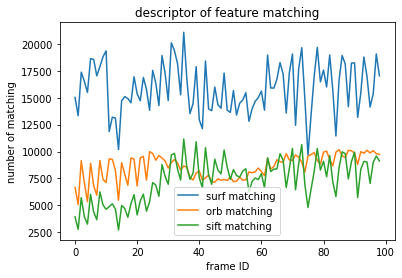

In [24]:

frame_idx,matching_num_surf,matching_num_orb,matching_num_sift
print(frame_idx,matching_num_surf,matching_num_orb,matching_num_sift)
frame_idx=frame_idx[:99]

matching_num_surf=matching_num_surf[:99]
matching_num_sift=matching_num_sift[:99]
matching_num_orb=matching_num_orb[:99]
print(matching_num_surf[57])

plt.plot(frame_idx,matching_num_surf,label='surf matching')  # 画线并添加图例legend
plt.plot(frame_idx,matching_num_orb,label='orb matching')   # 画线并添加图例legend
plt.plot(frame_idx,matching_num_sift,label='sift matching') 
plt.legend()  # 展示图例legend
plt.xlabel('frame ID')  # 给 x 轴添加坐标轴信息
plt.ylabel('number of matching')  # 给 y 轴添加坐标轴信息
plt.title('descriptor of feature matching')  # 添加图片标题
plt.savefig("comparison of feature detector with 3 different descriptor.jpg")

In [21]:
# frame_idx2=[]
# frame_idx_orb2=[]
# matching_num_orb2=[]
# frame_idx_sift2=[]
# matching_num_sift2=[]
# frame_idx_surf2=[]
# matching_num_surf2=[]
frame_idx2,matching_num_surf2,matching_num_orb2,matching_num_sift2=featurematchmetric(FLANN,MIN_MATCH_COUNT=2000)   


good len 1235
good len 425
good len 271
frame [0]
surf 1235
orb 425
sift 271
good len 807
good len 415
good len 209
frame [0, 1]
surf 807
orb 415
sift 209
good len 1426
good len 653
good len 389
frame [0, 1, 2]
surf 1426
orb 653
sift 389
good len 1108
good len 478
good len 252
frame [0, 1, 2, 3]
surf 1108
orb 478
sift 252
good len 705
good len 422
good len 228
frame [0, 1, 2, 3, 4]
surf 705
orb 422
sift 228
good len 1550
good len 597
good len 379
frame [0, 1, 2, 3, 4, 5]
surf 1550
orb 597
sift 379
good len 999
good len 463
good len 265
frame [0, 1, 2, 3, 4, 5, 6]
surf 999
orb 463
sift 265
good len 732
good len 394
good len 282
frame [0, 1, 2, 3, 4, 5, 6, 7]
surf 732
orb 394
sift 282
good len 1381
good len 536
good len 372
frame [0, 1, 2, 3, 4, 5, 6, 7, 8]
surf 1381
orb 536
sift 372
good len 1028
good len 463
good len 235
frame [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
surf 1028
orb 463
sift 235
good len 885
good len 396
good len 238
frame [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
surf 885
orb 396
sift 2

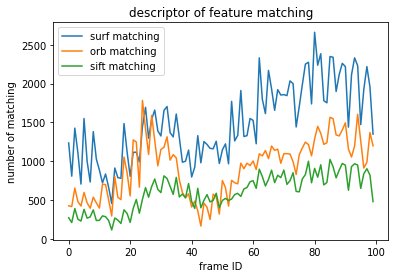

In [23]:
plt.plot(frame_idx2,matching_num_surf2,label='surf matching')  # 画线并添加图例legend
plt.plot(frame_idx2,matching_num_orb2,label='orb matching')   # 画线并添加图例legend
plt.plot(frame_idx2,matching_num_sift2,label='sift matching') 
plt.legend()  # 展示图例legend
plt.xlabel('frame ID')  # 给 x 轴添加坐标轴信息
plt.ylabel('number of matching')  # 给 y 轴添加坐标轴信息
plt.title('descriptor of feature matching')  # 添加图片标题
plt.savefig("FLANN comparison of feature detector with 3 different descriptor.jpg")

Notice that FLANN method contains less matching method, the threshold matching count number can be less than 500.